In [163]:
import urllib3
import configparser

import numpy as np
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf

from functools import reduce
from sklearn.manifold import TSNE
from elasticsearch import Elasticsearch

In [37]:
urllib3.disable_warnings()

config = configparser.ConfigParser()
config.read('../server.ini');

In [ ]:
es = Elasticsearch(
    config['ELASTIC']['path'],
    verify_certs=False
)

In [39]:
es.info()

{'name': '1bb166804bb3',
 'cluster_name': 'docker-cluster',
 'cluster_uuid': 'm81m9H08RKigCdwIje8C6w',
 'version': {'number': '8.11.0',
  'build_flavor': 'default',
  'build_type': 'docker',
  'build_hash': 'd9ec3fa628c7b0ba3d25692e277ba26814820b20',
  'build_date': '2023-11-04T10:04:57.184859352Z',
  'build_snapshot': False,
  'lucene_version': '9.8.0',
  'minimum_wire_compatibility_version': '7.17.0',
  'minimum_index_compatibility_version': '7.0.0'},
 'tagline': 'You Know, for Search'}

In [ ]:
print('Downloading pre-trained embeddings from tensorflow hub...')
tf.disable_eager_execution()
embed = hub.Module('https://tfhub.dev/google/universal-sentence-encoder/2')
text_ph = tf.placeholder(tf.string)
embeddings = embed(text_ph)
print('Done.')

In [ ]:
print('Creating tensorflow session...')
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())
session.run(tf.tables_initializer())
print('Done.')

In [165]:
def parse_ground_truth():
    grounds = []
    
    with open('../data/ground.txt') as file:
        lines = [line for line in file.read().split('\n') if line != '']
        
        for ind in range(0, len(lines)-1, 2):
            grounds.append((lines[ind], lines[ind+1]))
    
    return grounds

In [222]:
def get_precision(frequencies, ground_truth):
    raw_pos = []
    positions = []

    for ind1, frequency in enumerate(frequencies):
        for ind2, element in enumerate(frequency):
            if ground_truth[ind1][1].strip().lower() in element.strip().lower():
                raw_pos.append(ind2 + 1)
                positions.append(1 / (ind2 + 1))
                break
        else:
            positions.append(0)

    return (
        sum(positions) / len(positions),
        raw_pos,
        reduce(lambda pre, el: pre + 1 if el != 0 else pre, positions, 0),
        len(positions)
    )

In [209]:
def get_recall(correct, length):
    return correct / length

In [210]:
names = []
vectors = []
grounds_truths = parse_ground_truth()

for ground in grounds_truths:
    tmp = []
    query_vector = session.run(embeddings, feed_dict={text_ph: [ground[0]]}).tolist()[0]
    
    knn_query = {
        'knn': {
            'field': 'document_vector',
            'query_vector': query_vector,
            'k': 5,
            'num_candidates': 3992
        }
    }
    
    results = es.search(index='oa-specifications', body=knn_query)['hits']['hits']
    
    for result in results:
        tmp.append(result['_source']['name'])
        vectors.append(result['_source']['document_vector'])
    
    vectors.append(query_vector)
    names.append(tmp)

In [228]:
prec, pos, correct_pred, preds = get_precision(names, grounds_truths)
rec = get_recall(correct_pred, preds)

print(f'Precision: {str(prec)[:3]}')
print(f'Recall: {str(rec)[:3]}\n')

print('Position in which ground truth was found:')
for ind, position in enumerate(pos):
    print(f'\t"{grounds_truths[ind][1]}" was found at position #{position}')

Precision: 0.6
Recall: 1.0

Position in which ground truth was found:
	"NFL v3" was found at position #1
	"AWS IoT Secure Tunneling" was found at position #4
	"Transport Department" was found at position #4
	"Text Analytics & Sentiment Analysis API | api.text2data.com" was found at position #4
	"MailboxValidator Free Email Checker" was found at position #1
	"Interzoid Country Data Standardization API" was found at position #1
	"Soccer v3 Projections" was found at position #1
	"PolicyClient" was found at position #1
	"NetworkManagementClient" was found at position #3
	"Interzoid Get Weather City API" was found at position #2


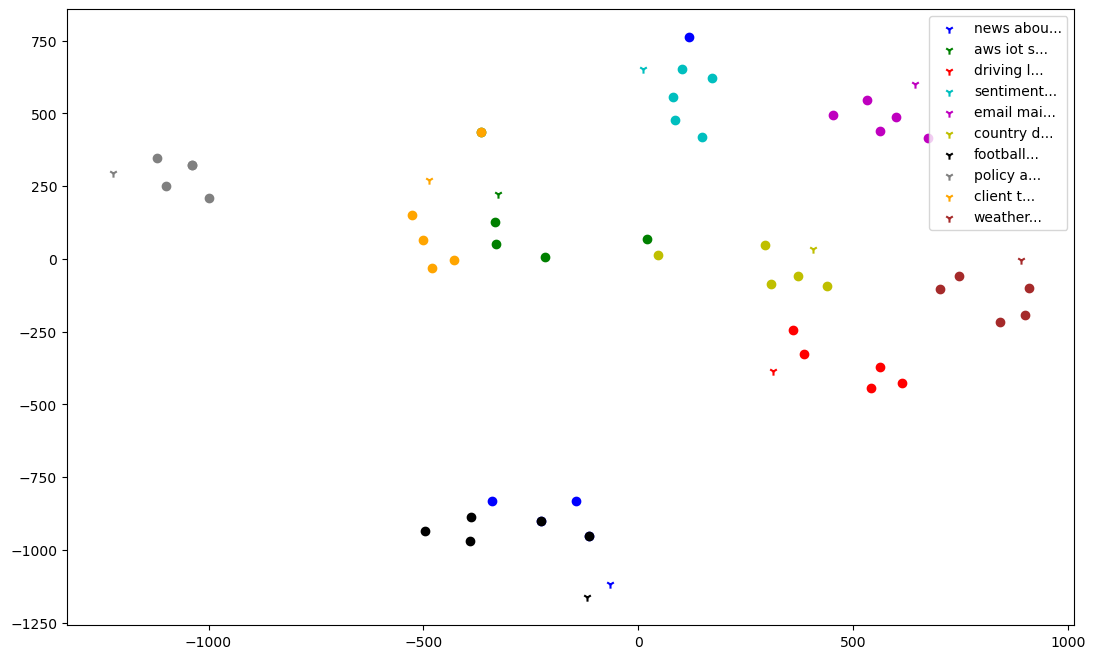

In [230]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'gray', 'orange', 'brown']
queries = ['news abou...', 'aws iot s...', 'driving l...', 'sentiment...', 'email mai...', 'country d...', 'football...', 'policy a...', 'client t...', 'weather...']

data = TSNE(perplexity=5, n_iter=3000).fit_transform(np.array(vectors))
plt.figure(figsize=(13, 8))

for i in range(0, 60, 6):
    plt.scatter(data[i + 5, 0], data[i + 5, 1], marker='1', color=colors[int(i / 6)], label=queries[int(i / 6)])
    plt.scatter(data[i:i + 5, 0], data[i:i + 5, 1], marker='o', color=colors[int(i / 6)])

plt.legend()